## Hidden sampling experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy.interpolate import interp1d
from scipy.integrate import quad
from pathlib import Path
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

%cd ..

/Users/andrey/MIPT_projects/M1P_6_sem/2023-Project-119


### Defining usage and adherence

In [106]:
usage = 0.1
adherence = 0.9

In [107]:
# preparing our data
hidden_samples = Path(f"results/hidden_samples_e_{usage}_{adherence}")
p_values = []
f_t_list = []
steps = range(10, 10001, 10)

for folder in sorted(hidden_samples.iterdir()):
    if folder.name != '.DS_Store':
        for step in steps:
            data = pd.read_csv(f"{hidden_samples}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = data['y'] - data['y_pred']
            hst = np.histogram(data_hist, density=True, bins=200)
            f_t = interp1d(hst[1][:-1], hst[0], kind='linear', 
                           fill_value=0.0, bounds_error=False)
            _, p_value = normaltest(data['y'] - data['y_pred'])
            f_t_list.append(f_t)
            p_values.append(p_value)

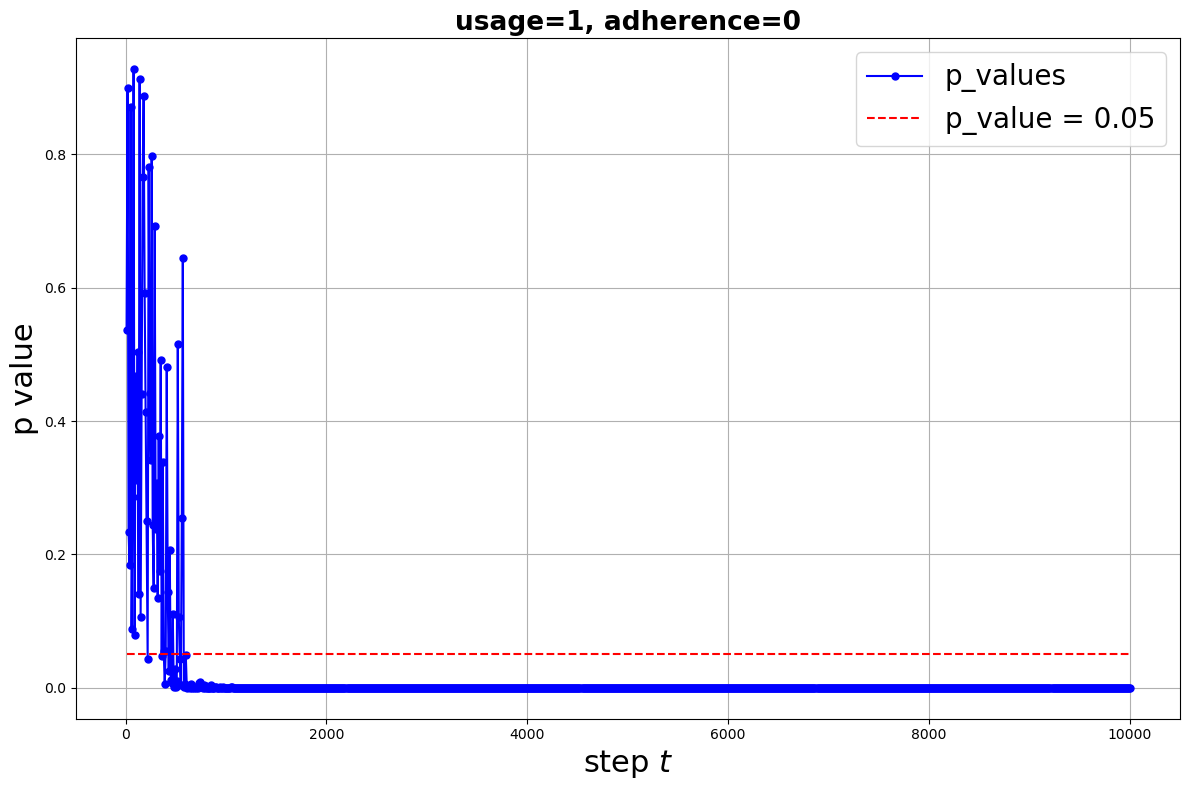

In [99]:
# plot means, deviations and p_values
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')

plt.xlabel(r"step $t$", fontsize=22)
plt.ylabel("p value", fontsize=22)

plt.plot(steps, p_values, label = "p_values", 
           color="blue", marker='o', markersize=5)
plt.plot(steps, [0.05]*len(steps), '--', color="red", label="p_value = 0.05")

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/p_sample_{usage}_{adherence}.png")
plt.show()

### Making hists

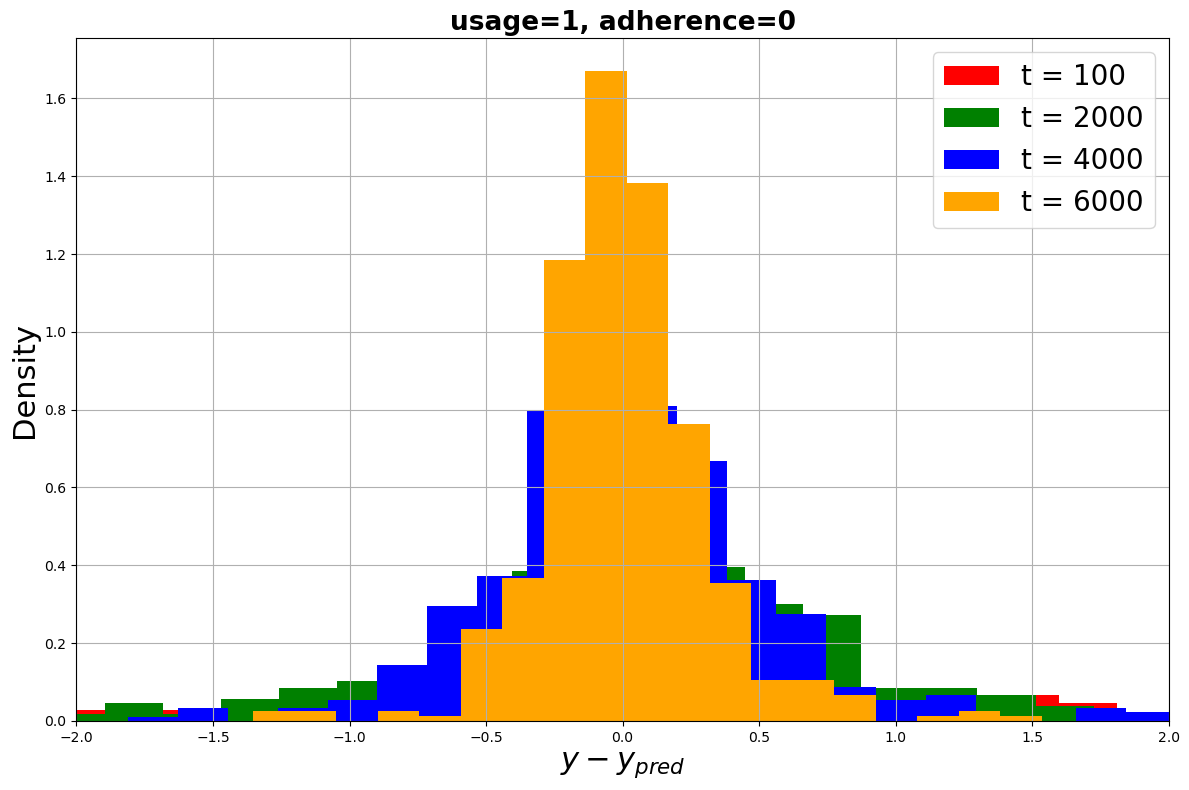

In [100]:
# plot histograms
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')
plt.xlabel(r"$y - y_{pred}$", fontsize=22)
plt.ylabel("Density", fontsize=22)
plt.xlim((-2, 2))

colors = ['red', 'green', 'blue', 'orange', 'purple',
          'cyan', 'pink', 'brown', 'black', 'olive']

steps_hist = [100, 2000, 4000, 6000]
for folder in sorted(hidden_samples.iterdir()):
    if folder.name != '.DS_Store':
        for step, color in zip(steps_hist, colors):
            data = pd.read_csv(f"{hidden_samples}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = np.array(data['y'] - data['y_pred'])
            hst = np.histogram(data_hist, density=True, bins=30)
            plt.hist(data_hist, bins=250, label=f"t = {step}", color=color,
                     density=True, stacked=True)
            f_t = interp1d(hst[1][:-1], hst[0], kind='cubic', 
                           fill_value=0.0, bounds_error=False)
            x_axis = np.linspace(-2, 2, 3000)
            #plt.plot(x_axis, f_t(x_axis), label=f"t = {step}", color=color)

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/hist_sample_{usage}_{adherence}.png")
plt.show()

### Limit to delta function

In [109]:
# preparing data to 1-st experiment
f_t0_list = []
integrals = []
kappa = 1
for f_t in f_t_list:
    f_t0_list.append(float(f_t(0.)))
    integral, _ = quad(f_t, -kappa, kappa)
    integrals.append(integral)

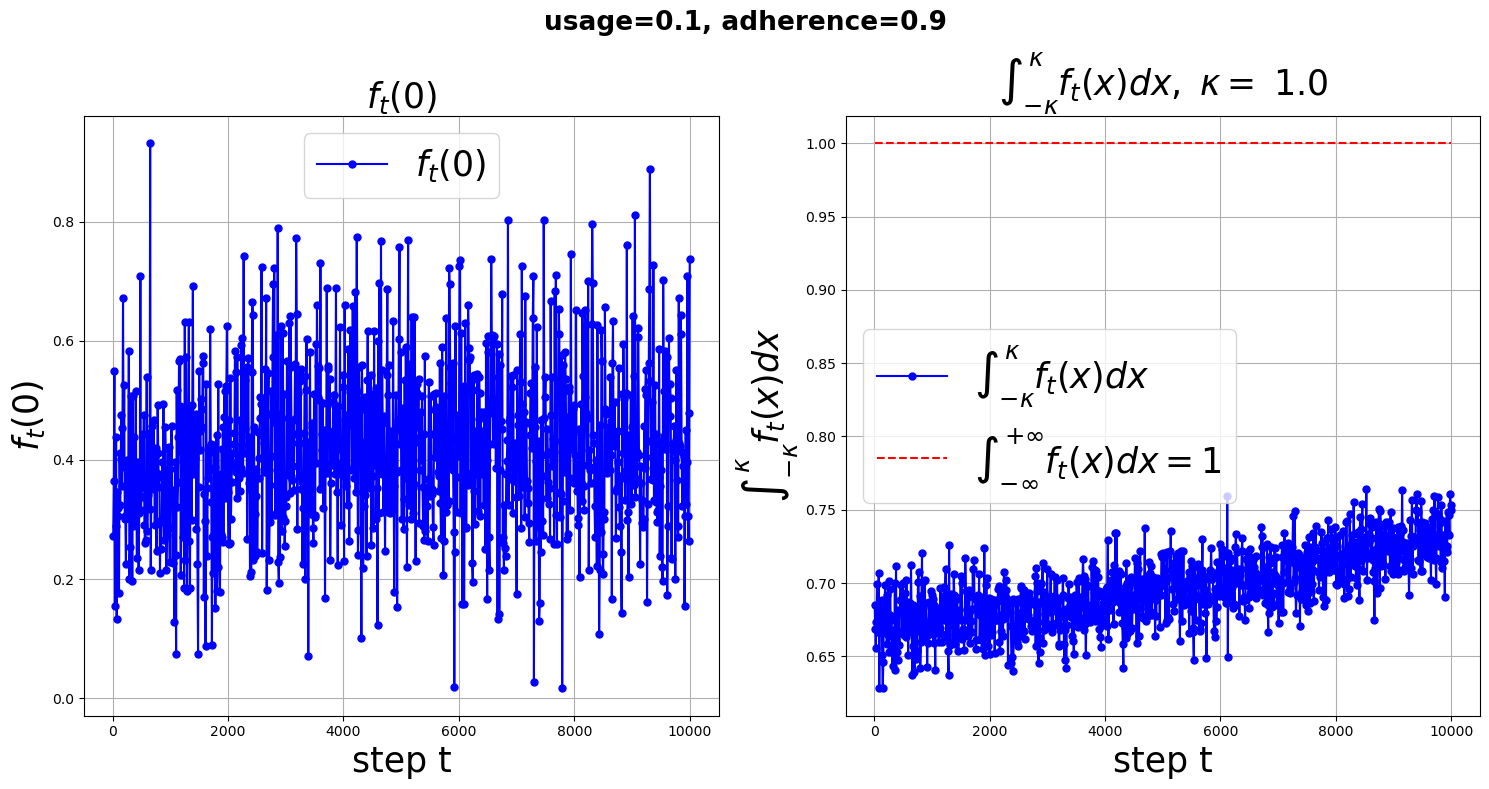

In [110]:
# plot f_t(0) and int_{-kappa}^{kappa}f_t(x)dx
plot, ax = plt.subplots(1, 2, figsize=(15, 8))
plot.suptitle(f"usage={usage}, adherence={adherence}", 
              fontsize=19, fontweight='bold')

ax[0].set_title(r"$f_t(0)$", fontsize=25, fontweight='bold')
ax[0].set_xlabel("step t", fontsize=25)
ax[0].set_ylabel(r"$f_t(0)$", fontsize=25)
ax[0].plot(steps, f_t0_list, label = r"$f_t(0)$", 
           color="blue", marker='o', markersize=5)
ax[0].legend(fontsize=25)
ax[0].grid()

ax[1].set_title(r"$\int_{-\kappa}^{\kappa}f_t(x)dx,~ \kappa = $ %.1f" % kappa, 
                fontsize=25)
ax[1].set_xlabel("step t", fontsize=25)
ax[1].set_ylabel(r"$\int_{-\kappa}^{\kappa}f_t(x)dx$", fontsize=25)
ax[1].plot(steps, integrals, label = r"$\int_{-\kappa}^{\kappa}f_t(x)dx$", 
           color="blue", marker='o', markersize=5)
ax[1].plot(steps, [1]*len(steps), '--', color="red", 
           label=r"$\int_{-\infty}^{+\infty}f_t(x)dx = 1$")
ax[1].legend(fontsize=25)
ax[1].grid()

plt.tight_layout()
#plt.savefig(f"figures/ft0_sample_{usage}_{adherence}.png")
plt.show()

### Semigroup chek

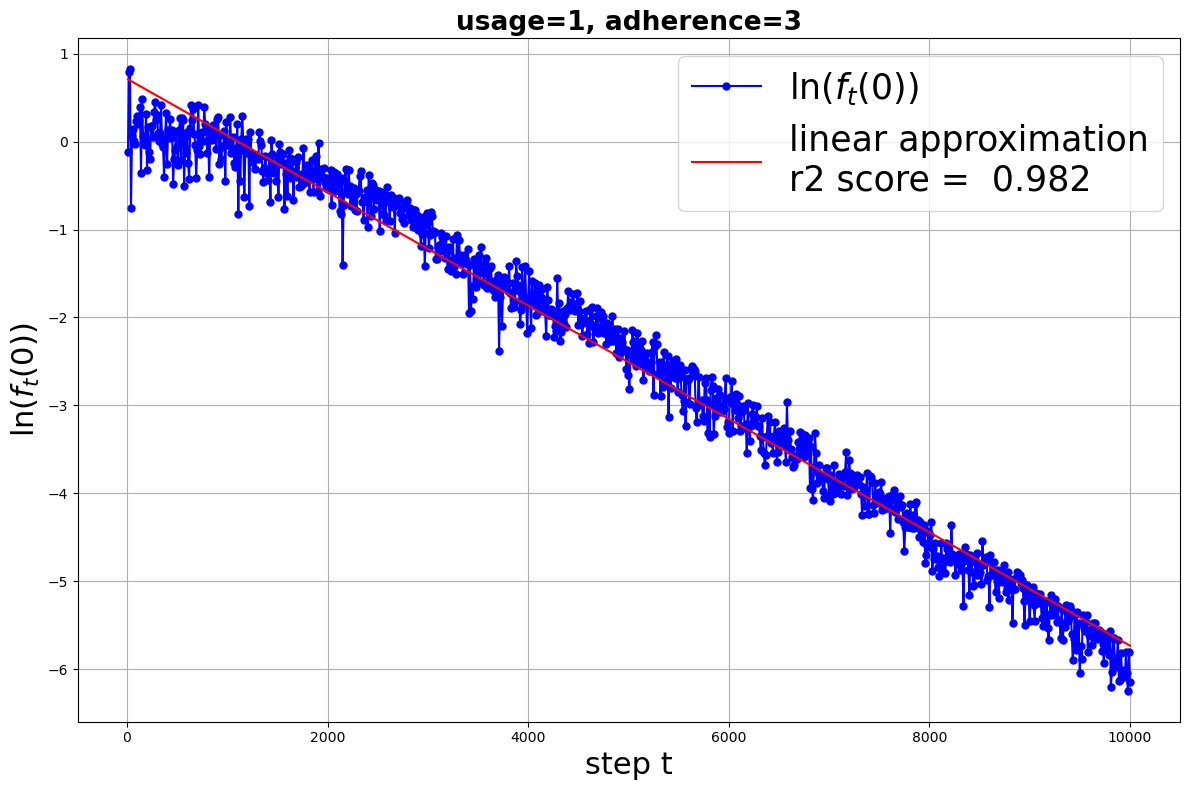

In [105]:
# plot ln(f_t(0)) 
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')

plt.xlabel("step t", fontsize=22)
plt.ylabel(r"$\ln(f_t(0))$", fontsize=22)
plt.plot(steps, np.log(f_t0_list), label = r"$\ln(f_t(0))$", 
         color="blue", marker='o', markersize=5)

k, b = np.polyfit(steps, np.log(f_t0_list), deg=1)
r2score = r2_score(np.log(f_t0_list), k * steps + b)

plt.plot(steps, k*steps + b, '-', color='red', 
         label='linear approximation\nr2 score =  %.3f' % r2score)

plt.legend(fontsize=25)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/semigroup_sample_{usage}_{adherence}.png")
plt.show()

### Moments

In [82]:
# functions to calculate k-th moments
def k_moment(k, func):
    new_func = lambda x : x**k * func(x)
    integral, _ = quad(new_func, -np.inf, np.inf)
    return integral

In [83]:
# prepare moments_k(t)
N = 5
moments = {}
for k in range(1, N+1):
    moments[k] = []
    for f_t in f_t_list:
        moment_t = k_moment(k, f_t)
        moments[k].append(moment_t)

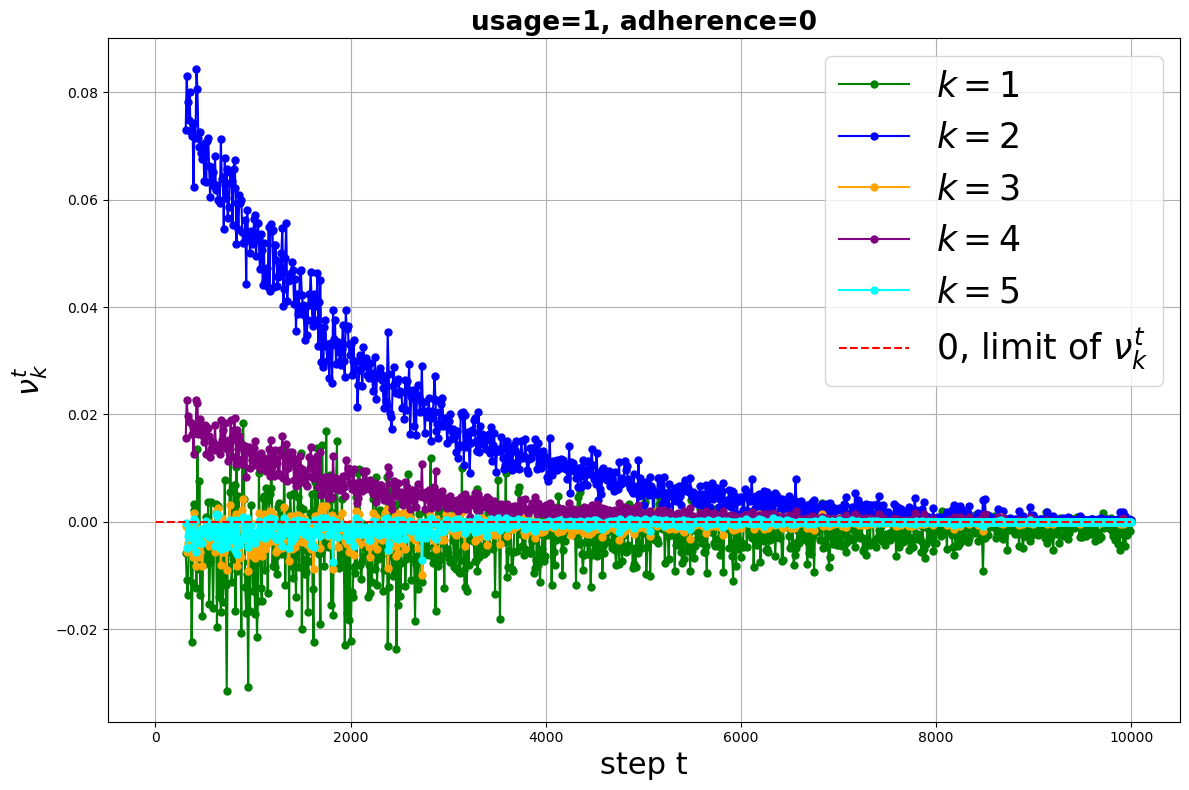

In [85]:
# plot moment_k(t)
plt.figure(figsize=(12, 8))
plt.title(f"usage={usage}, adherence={adherence}",
          fontsize=19, fontweight='bold')

plt.xlabel("step t", fontsize=22)
plt.ylabel(r"$\nu_k^t$", fontsize=22)

for k, moment_t, color in zip(moments.keys(), moments.values(), colors[1:]):
    plt.plot(steps[30:], moment_t[30:], label = r"$k = %i$" % k, 
             color=color, marker='o', markersize=5)

plt.plot(steps, [0]*len(steps), '--', label = r"0, limit of $\nu_k^t$", 
         color="red")
plt.legend(fontsize=25)
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/moments_sample_{usage}_{adherence}.png")
plt.show()